<a href="https://colab.research.google.com/github/TzurV/TestMe/blob/master/pytorch_nn_tutorial_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://pytorch.org/tutorials/beginner/nn_tutorial.html
#=========================================================

from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [0]:
import pickle
import gzip
from matplotlib import pyplot
import numpy as np

# This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        

In [25]:
#https://ipython.readthedocs.io/en/stable/interactive/magics.html


#Print all interactive variables, with some minimal formatting.
print(" --- %who ----")
%who
# Return a sorted list of all interactive variables.
print(" --- %who_ls ----")
%who_ls
# Like %who, but gives some extra information about each variable.
print(" --- %whos ----")
%whos

# https://medium.com/@chrieke/jupyter-tips-and-tricks-994fdddb2057
# stops and interactive python command line runs !
#%debug

 --- %who ----
DATA_PATH	 F	 FILENAME	 PATH	 Path	 URL	 accuracy	 bias	 bs	 
c	 content	 f	 gzip	 log_softmax	 loss_func	 math	 model	 n	 
np	 pickle	 preds	 pyplot	 requests	 torch	 weights	 x_train	 x_valid	 
xb	 y_train	 y_valid	 yb	 
 --- %who_ls ----
 --- %whos ----
Variable      Type         Data/Info
------------------------------------
DATA_PATH     PosixPath    data
F             module       <module 'torch.nn.functio<...>/torch/nn/functional.py'>
FILENAME      str          mnist.pkl.gz
PATH          PosixPath    data/mnist
Path          type         <class 'pathlib.Path'>
URL           str          http://deeplearning.net/data/mnist/
accuracy      function     <function accuracy at 0x7fcb49e97510>
bias          Tensor       tensor([0., 0., 0., 0., 0<...> 0.], requires_grad=True)
bs            int          64
c             int          784
content       bytes        b'\x1f\x8b\x08\x08\x14UOK<...>\x84\x1b\x04o\xd6(\x1e\r'
f             GzipFile     <gzip on 0x7fcb49e964a8>
gzip

(50000, 784)


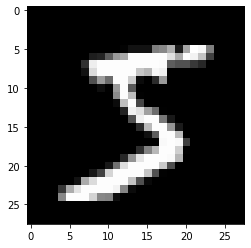

In [26]:
#Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)


In [27]:
#PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

import torch
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [28]:
import math

# We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n)).
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
    
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

yb = y_train[0:bs]
print(loss_func(preds, yb))



tensor([-2.3821, -2.3080, -2.5421, -2.8338, -2.8057, -2.0847, -2.2849, -2.3061,
        -1.7278, -2.2370], grad_fn=<SelectBackward>) torch.Size([64, 10])
tensor(2.3651, grad_fn=<NllLossBackward>)


In [0]:
## Using torch.nn.functional ===

import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

# Note that we no longer call log_softmax in the model function. 
# Let’s confirm that our loss and accuracy are the same as before:

print(loss_func(model(xb), yb), accuracy(model(xb), yb))




tensor(2.3651, grad_fn=<NllLossBackward>) tensor(0.0938)


In [37]:
#@Refactor using nn.Module

from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

#we first have to instantiate our model:
model = Mnist_Logistic()

print("1> ", loss_func(model(xb), yb))

# for our training loop
# we can take advantage of model.parameters() and model.zero_grad() 
# (which are both defined by PyTorch for nn.Module) 
# to make those steps more concise and less prone to the error 
# of forgetting some of our parameters, particularly if we had a more 
# complicated model:


lr = 0.5  # learning rate
epochs = 4  # how many epochs to train for


from torch import optim

#We’ll define a little function to create our model and optimizer so we can reuse it in the future.
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print("2> ", loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print("3> ", loss_func(model(xb), yb))

1>  tensor(2.5194, grad_fn=<NllLossBackward>)
2>  tensor(2.3521, grad_fn=<NllLossBackward>)
3>  tensor(0.0664, grad_fn=<NllLossBackward>)


# Refactor using Dataset

[link text](https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-dataset)


PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python’s standard len function) and a __getitem__ function as a way of indexing into it. This tutorial walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of Dataset.

PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.
